# **Sentiment Analysis using State-of-the-Art Text Classification Algorithms**

Evangelidakis Leandros, leandrosevag@hotmail.com


---



# **Introduction**

In the modern age of social networks, analyzing all the available information from user comments, documents etc. can be extemely time consuming. With AI we can automate tasks like that and save resources. In recent years, Deep Learning models achieve great results in understantding language models and is the best approach to Natural Language Processing (NLP) problems.

Several popular NLP applications for text data are:
  - Sentiment Analysis
  - Language Translation
  - Text Prediction
  - Text Summarization
  - Topic Modeling

In this notebook we are going to examine the problem of Text Classification for Sentiment Analysis, which is the task of identifiying the emotional tone of some text. This could mean, classifying some text as positive 🙂 or negative 😞 (Binomial Classification), or, we can extend this task for classifying more than two states e.x. Positive 🙂,Neutral 😐,Negative 😞 etc. (MultiClass Classification). Here we are going to examine the first case.


The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) we used comes from Stanford University and contains 50.000 movie reviews extracted from IMDB database. Half of them are used for training and the other half for validation.

We will use several of the current state-of-the-art Machine Learning algorithms available for this task.

Algorithms Used:
  - [NBSVM](https://aclanthology.org/P12-2018.pdf) ( Naive Bayes Support Vector Machines )
  - [fastTEXT](https://arxiv.org/pdf/1607.01759.pdf)
  - [BERT](https://arxiv.org/pdf/1607.01759.pdf)
  - [DistilBERT](https://arxiv.org/pdf/1910.01108.pdf)

# **Importing libraries and dataset**

[ktrain](https://arxiv.org/abs/2004.10703) is a lightweight wrapper library for TensorFlow Keras, which proved very usefull and easy to use.

In [ ]:
!pip install ktrain

In [2]:
%tensorflow_version 2.x
import ktrain
from ktrain import text
import tensorflow as tf
import os.path
import pandas as pd
import numpy as np
from glob import glob
import os,re,string
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize  

In [3]:
dataset = tf.keras.utils.get_file(fname="aclImdb.tar.gz",origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",extract=True,)

84140032/84125825 [==============================] - 1s 0us/step


In [4]:
datadir = os.path.join(os.path.dirname(dataset), 'aclImdb')
print(datadir)

/root/.keras/datasets/aclImdb


#**Preprocessing**

Preprocessing text data means removing all the unecesairy information from the text. This can include:

  - Tokenization (Splitting sentence into words)
  - Stop Words Removal (removing very common words like "the","a","an" etc.)
  - Stemming (Replacing word with its root word dancing->dance)
  - Special Character Removal (removing code tags, special characters etc.)
 

Our dataset contains html tags as well as several special characters we will remove

In [5]:
def clean_text(txtfile):
    #Removing HTML tags:
    cleaner = re.compile('<.*?>')
    cleaned = re.sub(cleaner, ' ', txtfile)

    #Removing special characters:
    regexp  = r'[^a-zA-z0-9\s]'
    cleaned = re.sub(regexp,' ', cleaned)

    #Stemming
    #stemmer = nltk.porter.PorterStemmer()
    #cleaned = ' '.join([stemmer.stem(word) for word in cleaned.split()])
    
    return(cleaned)
    

In [45]:
#Example:

clean_text('<br>text*</br>')

' text  '

In [6]:
def load_data(path,folders):
  
    reviews,sents=[],[]
    for idx,label in enumerate(folders):
        for txtname in glob(os.path.join(path,label,'*')):
            txtfile = open(txtname,'r', encoding="utf8").read()
            txtfile = clean_text(txtfile)
            reviews.append(txtfile)
            sents.append(idx)
            
    print('Data loaded succesfully')        
    return reviews,np.array(sents).astype(np.int8)  

Now it's time to split into training and test set

In [44]:
x_train,y_train = load_data(f'{datadir}/train',['neg','pos'])
x_test,y_test   = load_data(f'{datadir}/test' ,['neg','pos'])

Data loaded succesfully
Data loaded succesfully


Here is an example of a review:

In [45]:
x_train[0]

'I had somewhat high hopes for this since I like Tim Roth  I was not pleased with this film  I liked the Ang Lee The Hulk a few years back so I figured this would have more of a bang to it  First I was very disappointed with John Hurt s performance here  He looks as if his eyebrows were re shaped for this  His performance was not convincing  He was not as good as one would expect  Tim Roth is cool as always here  The Gama thing didn t really stick to the original story line I don t think  I guess the best part of the film was the end  It had some cool action  The only problem with the original was that it was too long  This one is not as long but it got a bit boring at times  I remember some time ago when Walmart had this movie really cheap for sale and I always wondered why   Now I know  I was hoping to to get blown away  but I was not '

In [9]:
(x_train,y_train),(x_test,y_test),preproc = text.texts_from_array(x_train=x_train,y_train=y_train,x_test=x_test,y_test=y_test,max_features=80000,
                                                                  maxlen=2000,ngram_range=2,preprocess_mode='standard',class_names=['neg','pos'])

language: en
Word Counts: 74980
Nrows: 25000
25000 train sequences
train sequence lengths:
	mean : 238
	95percentile : 610
	99percentile : 929
Adding 2-gram features
max_features changed to 1465722 with addition of ngrams
Average train sequence length with ngrams: 475
train (w/ngrams) sequence lengths:
	mean : 476
	95percentile : 1219
	99percentile : 1857
x_train shape: (25000,2000)
y_train shape: (25000, 2)
Is Multi-Label? False
25000 test sequences
test sequence lengths:
	mean : 231
	95percentile : 585
	99percentile : 907
Average test sequence length with ngrams: 421
test (w/ngrams) sequence lengths:
	mean : 422
	95percentile : 1060
	99percentile : 1629
x_test shape: (25000,2000)
y_test shape: (25000, 2)
task: text classification


The available algorithms from ktrain can be seen below:

In [40]:
text.print_text_classifiers()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) from keras_bert [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face transformers [https://arxiv.org/abs/1910.01108]


# **NBSVM**


---



We use the **NBSVM** algorithm while also adding word bigrams as features. This novel algorithm is motivated by the fact that Naive Bayes is good for short texts while SVM is better for longer text. So the idea is combining these two algorithms by applying the SVM into the NB log-count ratios.

To determine a good learning rate, SGD with Warm Restarts ([SGDR](https://arxiv.org/pdf/1608.03983.pdf)) is used.

In [34]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_folder(datadir,max_features=80000, maxlen=500,ngram_range=2,preprocess_mode='standard',classes=['pos', 'neg'])

detected encoding: utf-8
language: en
Word Counts: 88582
Nrows: 25000
25000 train sequences
train sequence lengths:
	mean : 237
	95percentile : 608
	99percentile : 923
Adding 2-gram features
max_features changed to 1501800 with addition of ngrams
Average train sequence length with ngrams: 473
train (w/ngrams) sequence lengths:
	mean : 474
	95percentile : 1215
	99percentile : 1845
x_train shape: (25000,500)
y_train shape: (25000, 2)
Is Multi-Label? False
25000 test sequences
test sequence lengths:
	mean : 230
	95percentile : 584
	99percentile : 900
Average test sequence length with ngrams: 418
test (w/ngrams) sequence lengths:
	mean : 419
	95percentile : 1052
	99percentile : 1613
x_test shape: (25000,500)
y_test shape: (25000, 2)


In [6]:
model = text.text_classifier('nbsvm', (x_train, y_train), preproc=preproc)

Is Multi-Label? False
compiling word ID features...
maxlen is 500
building document-term matrix... this may take a few moments...
rows: 1-10000
rows: 10001-20000
rows: 20001-25000
computing log-count ratios...
done.


In [7]:
model.save('/tmp/NBSVM_predictor')

In [24]:
#model.load('/tmp/NBSVM_predictor')

In [9]:
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test))

simulating training for different learning rates... this may take a few moments...
Train on 25000 samples
Epoch 1/1024
25000/25000 [==============================] - 10s 404us/sample - loss: 0.6664 - accuracy: 0.6862
Epoch 2/1024
20416/25000 [=======================>......] - ETA: 1s - loss: 0.3316 - accuracy: 0.9232

done.


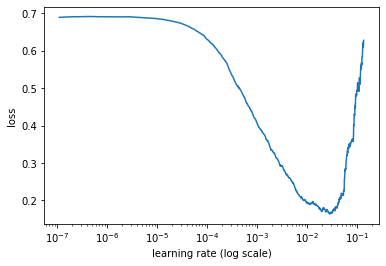

In [ ]:
learner.lr_find(show_plot=True)

In [ ]:
learner.reset_weights()

Model weights have been reset.


In [ ]:
learner.fit(0.001, 5, cycle_len=1)

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 12s 463us/sample - loss: 0.2134 - accuracy: 0.9333 - val_loss: 0.2482 - val_accuracy: 0.9118
Epoch 2/5
25000/25000 [==============================] - 12s 463us/sample - loss: 0.0760 - accuracy: 0.9832 - val_loss: 0.2372 - val_accuracy: 0.9154
Epoch 3/5
25000/25000 [==============================] - 11s 455us/sample - loss: 0.0435 - accuracy: 0.9941 - val_loss: 0.2320 - val_accuracy: 0.9169
Epoch 4/5
25000/25000 [==============================] - 12s 485us/sample - loss: 0.0281 - accuracy: 0.9972 - val_loss: 0.2299 - val_accuracy: 0.9160
Epoch 5/5
25000/25000 [==============================] - 12s 487us/sample - loss: 0.0193 - accuracy: 0.9987 - val_loss: 0.2293 - val_accuracy: 0.9157


We train the model for 5 epochs using .001 as learning rate. The model accuracy in testing dataset is 91.57% as seen above. Training took only 1 minute, which is by far the fastest between the other algorithms we are going to use.

# **fastText**


---



The **fastText** algorithm comes from Facebook AI Research and according to the authors it can process lots of data in orders of magnitude less training time that modern deep learning algorithms. The algorithm uses bag-of-ngrams instead of bag-of-words for calculating the word embeddings. Also, techniques for memory management (hashing-trick) are used in order to store and access the ngrams in an efficient way. The final classification layer uses logistic regression.

In [10]:
#(x_train, y_train), (x_test, y_test), preproc = text.texts_from_folder(datadir,max_features=80000, maxlen=2000,ngram_range=2,preprocess_mode='standard',classes=['pos', 'neg'])

In [11]:
model = text.text_classifier('fasttext', (x_train, y_train), preproc=preproc)

Is Multi-Label? False
compiling word ID features...
maxlen is 2000
done.


In [12]:
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test))

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
782/782 [==============================] - 45s 57ms/step - loss: 0.9604 - accuracy: 0.4992
Epoch 2/1024
782/782 [==============================] - 45s 57ms/step - loss: 0.6969 - accuracy: 0.5869
Epoch 3/1024
782/782 [==============================] - 16s 21ms/step - loss: 0.9202 - accuracy: 0.4918


done.
Visually inspect loss plot and select learning rate associated with falling loss


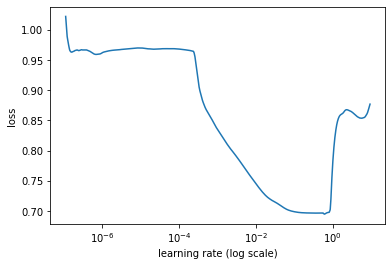

In [52]:
learner.lr_find(show_plot=True)

In [55]:
learner.reset_weights()

Model weights have been reset.


In [56]:
learner.autofit(0.01, 6)



begin training using triangular learning rate policy with max lr of 0.01...
Epoch 1/6
782/782 [==============================] - 47s 61ms/step - loss: 0.5753 - accuracy: 0.7016 - val_loss: 0.4002 - val_accuracy: 0.8336
Epoch 2/6
782/782 [==============================] - 47s 61ms/step - loss: 0.3885 - accuracy: 0.8296 - val_loss: 0.3459 - val_accuracy: 0.8556
Epoch 3/6
782/782 [==============================] - 48s 62ms/step - loss: 0.3073 - accuracy: 0.8694 - val_loss: 0.3160 - val_accuracy: 0.8667
Epoch 4/6
782/782 [==============================] - 49s 62ms/step - loss: 0.2520 - accuracy: 0.8989 - val_loss: 0.3089 - val_accuracy: 0.8718
Epoch 5/6
782/782 [==============================] - 48s 61ms/step - loss: 0.2209 - accuracy: 0.9147 - val_loss: 0.3152 - val_accuracy: 0.8753
Epoch 6/6
782/782 [==============================] - 48s 61ms/step - loss: 0.1992 - accuracy: 0.9226 - val_loss: 0.3135 - val_accuracy: 0.8778


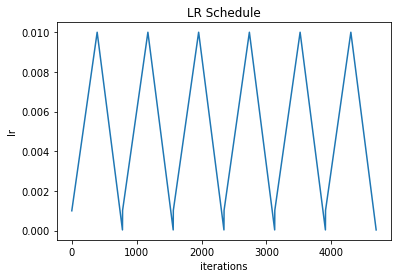

In [57]:
learner.plot('lr')

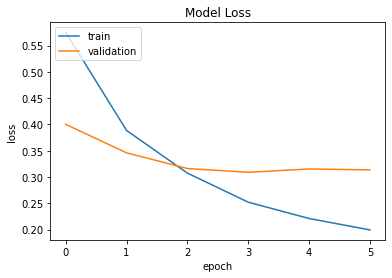

In [58]:
learner.plot('loss')


In [14]:
model.save('/tmp/fasttext')

Validation accuracy is above 87% and training took about 2456 seconds or 41 minutes.

# **BERT**


---





**B**idirectional **E**ncoder **R**epresentations from **T**ransformers or **BERT** is one of the best algorithms available for text classification and other NLP tasks. It is a pretrained model, trained on the whole Wikipedia corpus plus other sources where we only have to fine tune it for our specific task.

There are several different version of the BERT model available. The one we use contains 768 hidden layers and 100 million parameters. BERT input data requires special preprocessing which is available in ktrain.

In [30]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_folder(datadir,maxlen=512,preprocess_mode='bert',train_test_names=['train','test'],classes=['pos', 'neg'])

detected encoding: utf-8
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [ ]:
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)
learner = ktrain.get_learner(model,train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=6)
#model.save('/tmp/BERT_model')

Is Multi-Label? False
maxlen is 512
done.


In [ ]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Train on 25000 samples
Epoch 1/1024
   48/25000 [..............................] - ETA: 2:39:50 - loss: 0.8893 - acc: 0.5417

In [ ]:
learner.fit_onecycle(2e-5, 1)




begin training using onecycle policy with max lr of 2e-05...
Train on 25000 samples, validate on 25000 samples
25000/25000 [==============================] - 8466s 339ms/sample - loss: 0.1282 - accuracy: 0.9545 - val_loss: 0.1590 - val_accuracy: 0.9424



As seen above, with only one epoch of training, the model achieves 94.24% of accuracy on validation data. Of course this great result comes with the price of training time ( 8466s or about 2.35 hours ).


# **DistilBERT**

**DistilBERT** is a light version of the BERT model. It is based on Distillation, a technique used to get most of the useful knowledge of one model, while requiring much less training time. In particular, DistilBERT manages to reduce the size of BERT by 40%, while retaining 97% of the original language understanding capabilities and being 60% faster.

In [ ]:
!pip install git+https://github.com/amaiya/eli5@tfkeras_0_10_1

In [62]:
trn, val, preproc = text.texts_from_folder(datadir, maxlen=512,preprocess_mode='distilbert',classes=['pos', 'neg'])

detected encoding: utf-8
preprocessing train...
language: en
train sequence lengths:
	mean : 234
	95percentile : 598
	99percentile : 913


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 229
	95percentile : 582
	99percentile : 901


In [63]:
model = text.text_classifier('distilbert', train_data=trn, preproc=preproc)


Is Multi-Label? False
maxlen is 512
done.


In [64]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)


In [68]:
learner.fit_onecycle(2e-5, 1)



begin training using onecycle policy with max lr of 2e-05...
4167/4167 [==============================] - 2161s 517ms/step - loss: 0.1526 - accuracy: 0.9444 - val_loss: 0.1793 - val_accuracy: 0.9314


In [80]:
learner


In [71]:
model.save('/tmp/distilbert')

In [72]:
!zip -r /tmp/distilbert.zip /tmp/distilbert

  adding: tmp/distilbert/ (stored 0%)
  adding: tmp/distilbert/variables/ (stored 0%)
  adding: tmp/distilbert/variables/variables.data-00000-of-00001 (deflated 12%)
  adding: tmp/distilbert/variables/variables.index (deflated 79%)
  adding: tmp/distilbert/saved_model.pb (deflated 92%)
  adding: tmp/distilbert/assets/ (stored 0%)
  adding: tmp/distilbert/keras_metadata.pb (deflated 94%)


We see that with only one training cycle we achieve 93.13% accuracy on validation dataset. 

In [59]:
predictor = ktrain.get_predictor(learner.model,preproc=transf)

In [ ]:
predictor.save('/tmp/distilbert_imdb')

In [ ]:
#predictor = ktrain.load_predictor('/tmp/distilbert_imdb')

# **Predicting Sentiments**


---



In this section we show how to use our models for predicting the sentiment in a text. Also, by using the explain() function of ktrain, we can visualize which words have a positive or a negative impact in the models prediction. This is computed using the [LIME](https://arxiv.org/pdf/1602.04938.pdf) method.

In [74]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [75]:
data = [ 'good for watching','good for nothing',
        'This movie got me the chills from the beggining.Stunning visuals and good performance',
        'I hated this movie','I have to do five projects at the same time.I guess u dont have to sleep every day.',
        'The film wasnt what i expected.In a bad way.',
        'I enjoyed this movie.Good production',
        ]

In [76]:
def sentiment_analysis(strings):
  print('Sentiments:\n ',predictor.get_classes())
  print('')
  print('-'*100)
  for sent in strings :
    print(sent,'|--->',predictor.predict(sent))
    print('-'*100)
  
  print('Probabilities:')  
  print(predictor.predict(strings, return_proba=True))

In [77]:
sentiment_analysis(data)

Sentiments:
  ['neg', 'pos']

----------------------------------------------------------------------------------------------------
good for watching |---> pos
----------------------------------------------------------------------------------------------------
good for nothing |---> neg
----------------------------------------------------------------------------------------------------
This movie got me the chills from the beggining.Stunning visuals and good performance |---> pos
----------------------------------------------------------------------------------------------------
I hated this movie |---> neg
----------------------------------------------------------------------------------------------------
I have to do five projects at the same time.I guess u dont have to sleep every day. |---> neg
----------------------------------------------------------------------------------------------------
The film wasnt what i expected.In a bad way. |---> neg
-----------------------------------

In [78]:
test = 'I was unlucky enough to have seen this at the Sidewalk Film Festival  Sidewalk as a whole was a disappointment and this movie was the final nail in the coffin  Being a devout fan of Lewis Carroll s  Alice  books I was very excited about this movie s premier  which only made it that much more uncomfortable to watch  Normally I m enthusiastic about modern re tellings if they are treated well  Usually it s interesting to see the parallels between the past and present within a familiar story  Unfortunately this movie was less of a modern retelling and more of a pop culture perversion  The adaptation of the original s characters seemed juvenile and usually proved to be horribly annoying  It probably didn t help that the actors weren t very good either  Most performances were ridiculously over the top  which I assume was either due to bad direction or an effort to make up for a bad script  I did not laugh once through out the duration of the film  All of the jokes were outdated references to not so current events that are sure to lose their poignancy as time goes by  Really  the only highlight of the film was the opening sequence in which the white rabbit is on his way to meet Alice  but even then the score was a poor imitation of Danny Elfman s work  Also  I d have to say that the conversion of the croquet game into a rave dance off was awful  It was with out a doubt the low point of the film   What a joke  Don t see this movie  After its conclusion I was genuinely angry'

In [79]:
predictor.explain(test)